## Hyperparameter tuning via Optuna for Binary MLP model

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
import torch
import optuna
import plotly

import pandas as pd
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


sys.path.append("..")
from utils.utils import df_stats
from MLP_utils.utils import data_split
from MLP_utils.utils import Dataset

# from MLP_utils.utils import build_model_custom
# from MLP_utils.utils import train_n_validate
from MLP_utils.utils import objective
from MLP_utils.utils import extract_best_trial_params
from MLP_utils.utils import optimized_model
from MLP_utils.utils import train_optimized_model
from MLP_utils.utils import plot_metric_vs_epoch
from MLP_utils.utils import test_optimized_model
from MLP_utils.utils import un_nest
from MLP_utils.utils import results_output
from MLP_utils.parameters import Parameters

params = Parameters()

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(
    file_path,
    low_memory=False,
)

Combine treatment with dosage to be able to discern treatments with different doses as a different condition

In [3]:
# Combine treatment and dose
df["Metadata_treatment"] = df["Metadata_treatment"] + "_" + df["Metadata_dose"]
print(df["Metadata_treatment"].unique())

# Generate df speceific to analysis and model
df = df.query(
    "Metadata_treatment == 'LPS_10µg/ml'| Metadata_treatment == 'Media only_0'"
)
print(df["Metadata_treatment"].unique())

df_stats(df)
# Drop na and reindex accordingly
df = df.dropna()
df.reindex()
# Check for Nans again
df_stats(df)
# Understand categorical data such as treatment and dosing
df[["Metadata_treatment", "Metadata_dose"]].drop_duplicates()
if params.SUBSET_OPTION:
    df = df.sample(n=params.SUBSET_NUMBER)
else:
    pass
# Code snipptet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
['LPS_10µg/ml' 'Media only_0']
The dimensions of the data are: (36718, 568)
Number of total missing values across all columns: 470
The dimensions of the data are: (36589, 568)
Number of total missing values across all columns: 0


### Setting up data for network training

In [4]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_treatment"] = le.fit_transform(df_descriptive["Metadata_treatment"])
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_treatment", axis=1)
df_values_Y = df_values["Metadata_treatment"]

X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    df_values_X, df_values_Y, 0.8, 0.1, 0.1
)

In [5]:
# produce data objects for train, val and test datasets
train_data = Dataset(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset(torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values))
test_data = Dataset(torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values))

IN_FEATURES = X_train.shape[1]
print("Number of in features: ", IN_FEATURES)
out_features = len(df_values["Metadata_treatment"].unique())
print("Number of out features: ", out_features)

Number of in features:  555
Number of out features:  2


In [6]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=params.BATCH_SIZE
)

In [7]:
# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective(
    trial, IN_FEATURES, train_loader, valid_loader, params, False
)
# Study is the object for model optimzation
study = optuna.create_study(direction="maximize")
# Here I appply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optinmized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective(study.best_trial, IN_FEATURES, train_loader, valid_loader, params, True)

[I 2023-03-20 07:50:11,038] A new study created in memory with name: no-name-044c4deb-690c-4fcc-aad3-b49e23b4884c
[I 2023-03-20 07:52:08,198] Trial 0 finished with value: 48.31921289969939 and parameters: {'n_layers': 6, 'n_units_l0': 25, 'dropout_0': 0.4, 'n_units_l1': 16, 'dropout_1': 0.4, 'n_units_l2': 32, 'dropout_2': 0.45000000000000007, 'n_units_l3': 9, 'dropout_3': 0.15000000000000002, 'n_units_l4': 11, 'dropout_4': 0.1, 'n_units_l5': 34, 'dropout_5': 0.2, 'learning_rate': 0.06416082580425224, 'optimizer': 'RMSprop', 'n_unit': 1}. Best is trial 0 with value: 48.31921289969939.
[I 2023-03-20 07:54:59,327] Trial 1 finished with value: 51.64717135829461 and parameters: {'n_layers': 10, 'n_units_l0': 5, 'dropout_0': 0.2, 'n_units_l1': 7, 'dropout_1': 0.35, 'n_units_l2': 5, 'dropout_2': 0.2, 'n_units_l3': 4, 'dropout_3': 0.30000000000000004, 'n_units_l4': 23, 'dropout_4': 0.25, 'n_units_l5': 24, 'dropout_5': 0.35, 'n_units_l6': 3, 'dropout_6': 0.2, 'n_units_l7': 44, 'dropout_7': 0.1,

Validation Accuracy: 78.93522820442743
Validation Loss: 0.45225003986745266
Training Accuracy: 77.30914557070138
Training Loss: 0.47307944166375504


In [8]:
optuna.visualization.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_intermediate_values(study)

In [10]:
# call function
param_dict = extract_best_trial_params(study.best_params)

In [11]:
# call the optimized trainig model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS, train_loader, valid_loader, IN_FEATURES, param_dict, params
)

Epoch 0: Validation loss decreased (inf --> 0.529411).  Saving model ...
	 Train_Loss: 0.6359 Train_Acc: 64.767 Val_Loss: 0.5294  BEST VAL Loss: 0.5294  Val_Acc: 71.987

Epoch 1: Validation loss decreased (0.529411 --> 0.516353).  Saving model ...
	 Train_Loss: 0.5996 Train_Acc: 71.863 Val_Loss: 0.5164  BEST VAL Loss: 0.5164  Val_Acc: 75.184

Epoch 2: Validation loss decreased (0.516353 --> 0.509006).  Saving model ...
	 Train_Loss: 0.5817 Train_Acc: 73.089 Val_Loss: 0.5090  BEST VAL Loss: 0.5090  Val_Acc: 75.950

Epoch 3: Validation loss decreased (0.509006 --> 0.504637).  Saving model ...
	 Train_Loss: 0.5694 Train_Acc: 73.827 Val_Loss: 0.5046  BEST VAL Loss: 0.5046  Val_Acc: 74.829

Epoch 4: Validation loss decreased (0.504637 --> 0.500889).  Saving model ...
	 Train_Loss: 0.5599 Train_Acc: 74.576 Val_Loss: 0.5009  BEST VAL Loss: 0.5009  Val_Acc: 76.934

Epoch 5: Validation loss decreased (0.500889 --> 0.497920).  Saving model ...
	 Train_Loss: 0.5525 Train_Acc: 75.023 Val_Loss: 0.4

In [12]:
training_stats = pd.DataFrame(
    zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
    columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
)

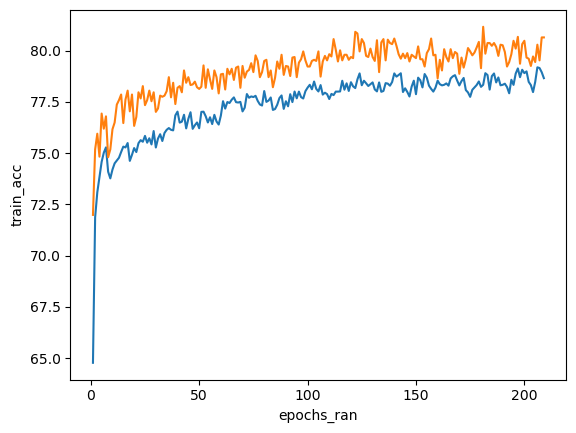

In [13]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_acc", "valid_acc")

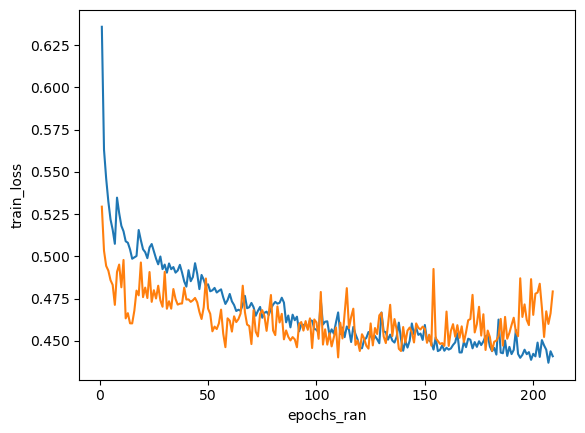

In [14]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_loss", "valid_loss")

In [15]:
# calling the testing function and outputing list values of tested model
y_pred_list, y_pred_prob_list = test_optimized_model(
    model, test_loader, IN_FEATURES, param_dict, params
)


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1768
           1       0.52      1.00      0.68      1891

    accuracy                           0.52      3659
   macro avg       0.51      0.50      0.34      3659
weighted avg       0.51      0.52      0.35      3659



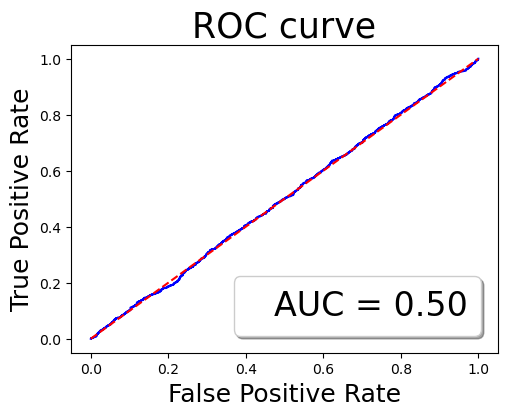

In [16]:
# Call visulalization function
results_output(y_pred_list, y_pred_prob_list, Y_test)